In [66]:
import sys
sys.path.append(r"C:\Users\trund\QRT")

import backtesting # To backtest the strategy
import eda_package

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
import yfinance as yf 

In [85]:
# TSA plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
import requests
import pandas as pd

url = "https://en.wikipedia.org/wiki/Nasdaq-100"

# Add a real browser User-Agent
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
html = response.text

# read_html from raw HTML instead of URL
tables = pd.read_html(html)

print(f"Loaded {len(tables)} tables")


Loaded 19 tables


C:\Users\trund\AppData\Local\Temp\ipykernel_24840\767392630.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


In [3]:
for i, df in enumerate(tables):
    print("TABLE", i)
    print("shape:", df.shape)
    print("columns:", df.columns.tolist())
    print(df.head(1).to_dict(orient="records"))
    print("-" * 60)

# To collapse a cell in a Jupyter Notebook, you can typically click on the blue bar to the left of the cell.
# In JupyterLab, there is a blue vertical bar that appears when you hover over the left side of a cell; clicking it will collapse the cell.
# In the classic Jupyter Notebook interface, you can also use keyboard shortcuts. In command mode (press Esc), you can use 'o' to toggle the output of the selected cell.


TABLE 0
shape: (11, 2)
columns: [0, 1]
[{0: 'Nasdaq-100 Index from 1985 to 2015', 1: 'Nasdaq-100 Index from 1985 to 2015'}]
------------------------------------------------------------
TABLE 1
shape: (2, 3)
columns: ['Category', 'All-Time Highs[5]', 'All-Time Highs[5].1']
[{'Category': 'Closing', 'All-Time Highs[5]': 24761.07, 'All-Time Highs[5].1': 'Monday, September 22, 2025'}]
------------------------------------------------------------
TABLE 2
shape: (26, 3)
columns: ['Milestone[6][obsolete\xa0source] (closing)', 'Date of Record (closing)[6]', 'Trading Days[6]']
[{'Milestone[6][obsolete\xa0source] (closing)': 1000, 'Date of Record (closing)[6]': 'July 8, 1997', 'Trading Days[6]': 3143}]
------------------------------------------------------------
TABLE 3
shape: (40, 4)
columns: ['Year', 'Closing level', 'Change in Index in Points', 'Change in Index in\xa0%']
[{'Year': 1985, 'Closing level': 132.29, 'Change in Index in Points': nan, 'Change in Index in\xa0%': nan}]
-----------------

After examination of the tables from the imports, tickers are obtained from tables[4] and tables[5]. In what follows we proceed with only those.

In [ ]:
# The current constituents of the NASDAQ 100:
current_const = tables[4]["Ticker"]

# Access the tickers
tickers = current_const.tolist()

# The historical constituents of the NASDAQ 100:
historical_const = tables[5]
historical_const

# When converting strings to datetime objects, pandas defaults to adding a midnight timestamp.
# To remove the time part, we can use the .dt.date accessor, which returns Python's datetime.date objects.
historical_const.loc[:, ("Date", "Date")] = pd.to_datetime(historical_const.loc[:, ("Date", "Date")], format="%B %d, %Y").dt.date
#print(historical_const.head())

# Set the date column as the index of the DataFrame
historical_const = historical_const.set_index(('Date', 'Date'))
historical_const.index.name = "Date" 
# The next block of code is to get all the tickers of the historical constituents that have been removed.

# Convert the string date to a datetime object to allow for comparison
date_considered = pd.to_datetime("2015-01-01").date()

# Filter the DataFrame to include only rows where the date is after the date_considered
historical_const = historical_const[historical_const.index > date_considered]

# Because the date is in descending order, the date_considered is at the bottom of the dataframe
added_tickers = historical_const.loc[:date_considered, ("Added", 'Ticker')].dropna().unique()
removed_tickers = historical_const.loc[:date_considered, ("Removed", 'Ticker')].dropna().unique().tolist()
all_tickers = []
all_tickers.extend(tickers)
all_tickers.extend(added_tickers)
all_tickers.extend(removed_tickers)

# To remove all the duplicates from the list
all_tickers = list(set(all_tickers))


# After retreiving all tickers that have been in the NASDAQ 100, we may retrieve the data from these tickers from yfinance.
nasdaq_data = yf.download(all_tickers, start="2015-01-01", group_by='ticker', auto_adjust=False, keepna=True, multi_level_index=False)



[*********************100%***********************]  209 of 209 completed

37 Failed downloads:
['CTXS', 'LMCK', 'ENDP', 'SPLK', 'CERN', 'XLNX', 'NDOI', 'WLTW', 'TCFCA', 'DISCK', 'MXIM', 'DISH', 'VIAB', 'TCFCB', 'YHOO', 'ALTR', 'CTRP', 'QRTEA', 'NLOK', 'ATVI', 'ALXN', 'ANSS', 'WBA', 'MYL', 'DTV', 'CELG', 'SGEN', 'DISCA']: YFTzMissingError('possibly delisted; no timezone found')
['LMCA', 'BRCM', 'LLTC', 'KRFT', 'SIAL', 'GMCR', 'SPLS', 'CTRX', 'WFM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-12-13)')


The conclusion from ChatGPT is that 
### <a> <center> We MUST obtain our data from LSEG and not yfinance, if we want to have a proper strategy. </center> </a>

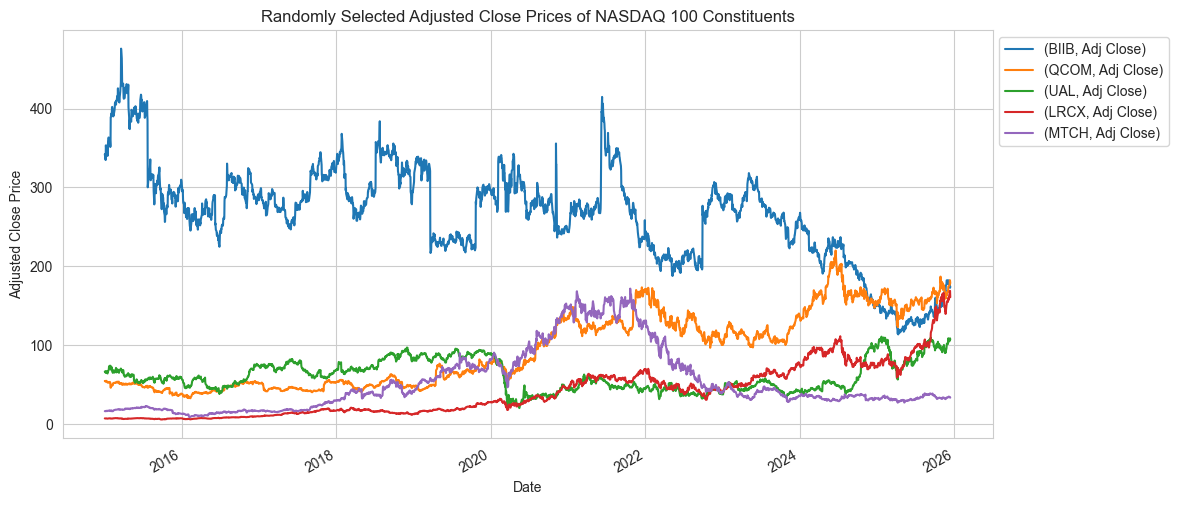

In [100]:
columnsOfInterest = [(column,"Adj Close") for column in nasdaq_data.columns.levels[0]]
adjCloseData = nasdaq_data.loc[:, columnsOfInterest]

# drop columns that are all NA 
adjCloseData.dropna(axis=1, how='all', inplace=True)

# Let's examine the data that have NA's but not all NA's, a sanity check to see how the data is changing
# This line of data looks for entries that have been delisted - isna() checks for NaN values, any() checks if any value in the column is NaN, to_numpy() converts the resulting Series to a NumPy array for indexing.
removedTickers = adjCloseData.loc[:, adjCloseData.isna().any().to_numpy()]
abnbColumn = removedTickers[('ABNB', 'Adj Close')]

# Just a sanity check - the sanity check passed, can go on to making some plots for a few randomly chosen columns to examine the time series data.

# Remove all columns that have any NA values for plotting 
columnsToPlot = adjCloseData.loc[:, ~(adjCloseData.isna().any(axis=0)).to_numpy()]

randomColumns = columnsToPlot.iloc[:, np.random.randint(0, columnsToPlot.shape[1], size=5)]
randomColumns.plot(figsize=(12, 6))
plt.title("Randomly Selected Adjusted Close Prices of NASDAQ 100 Constituents")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# EDA on Data 

## Basic Descriptive Statistic Plots

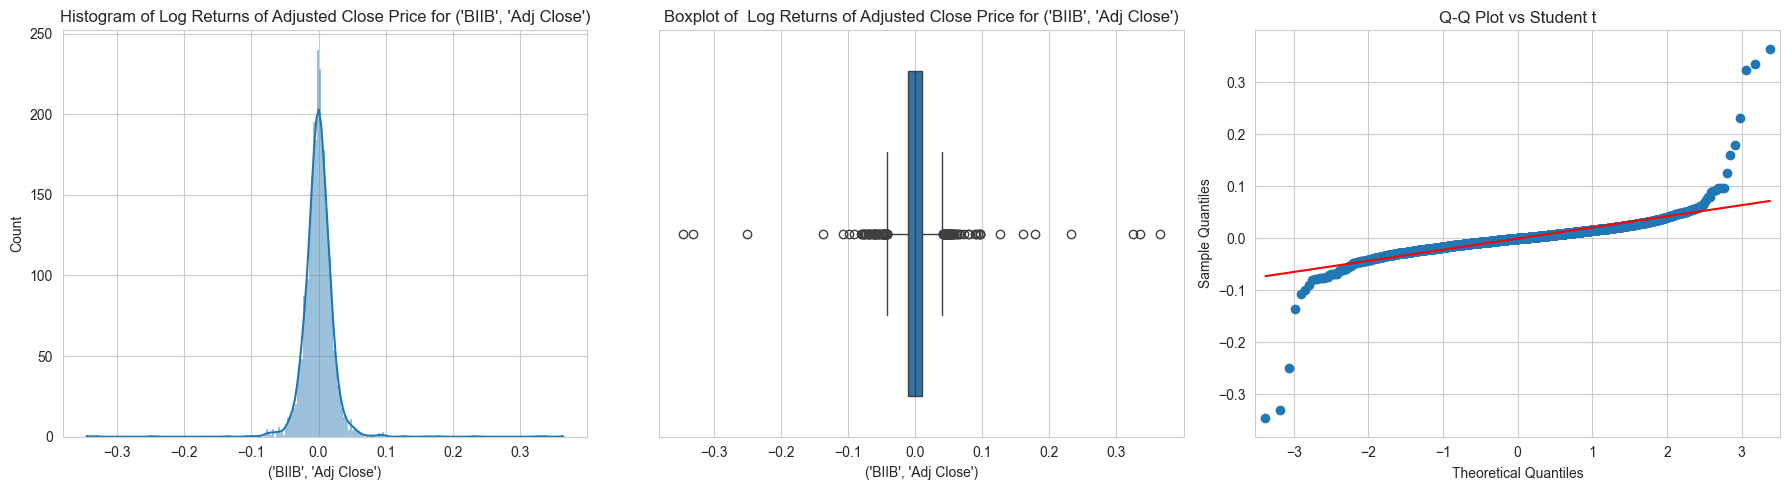

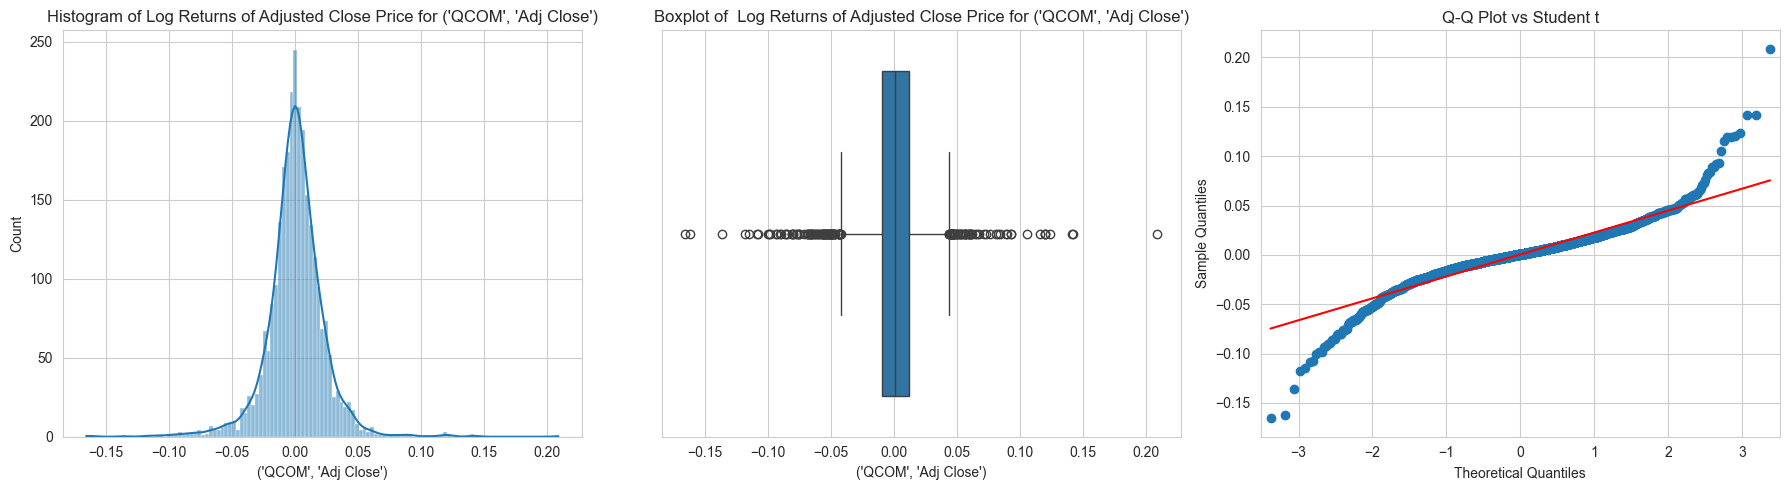

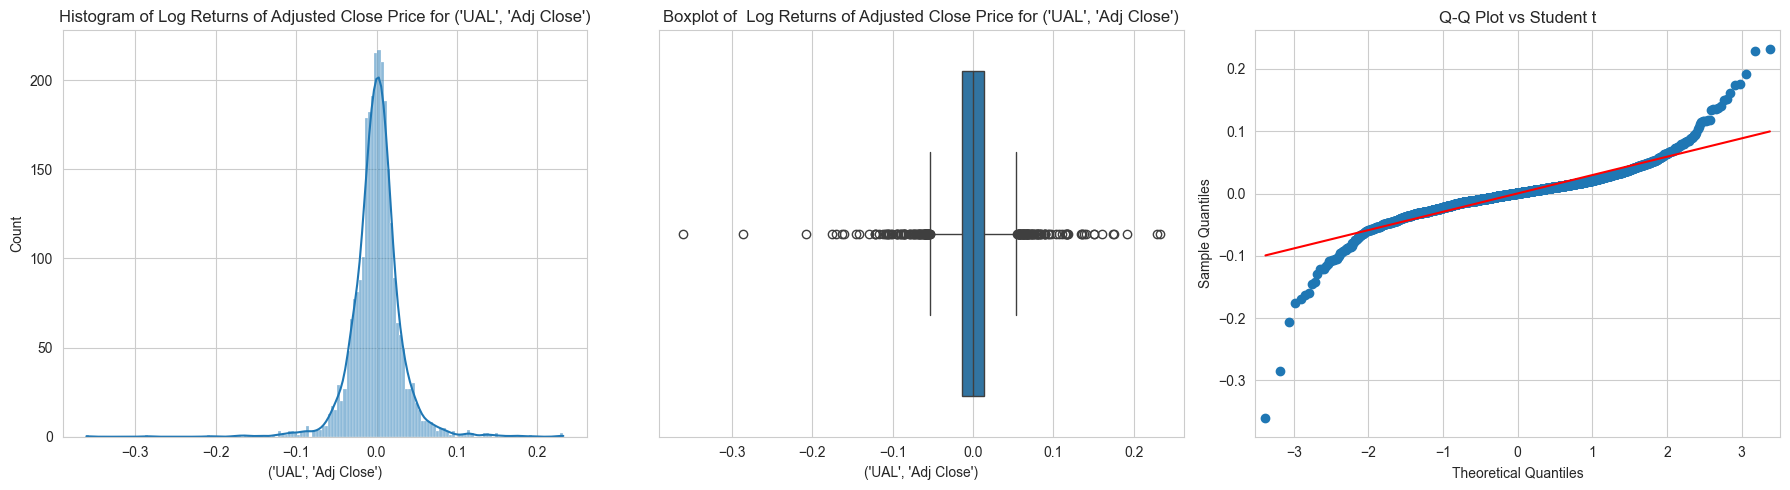

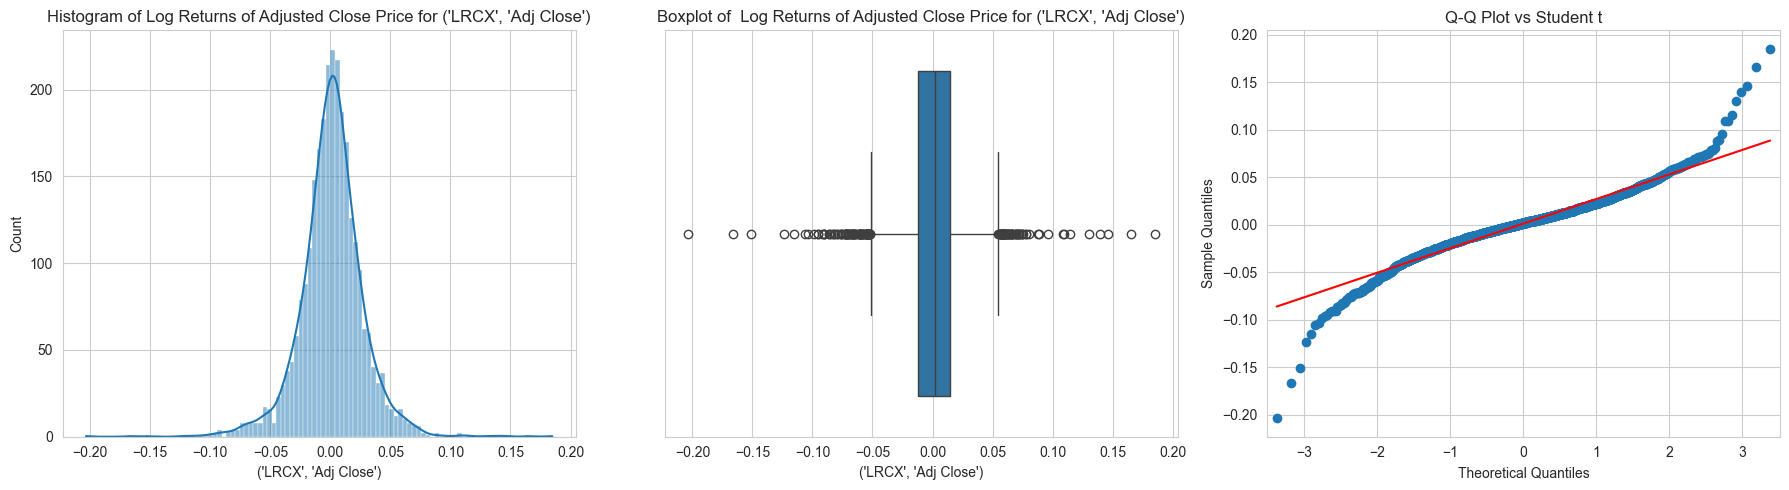

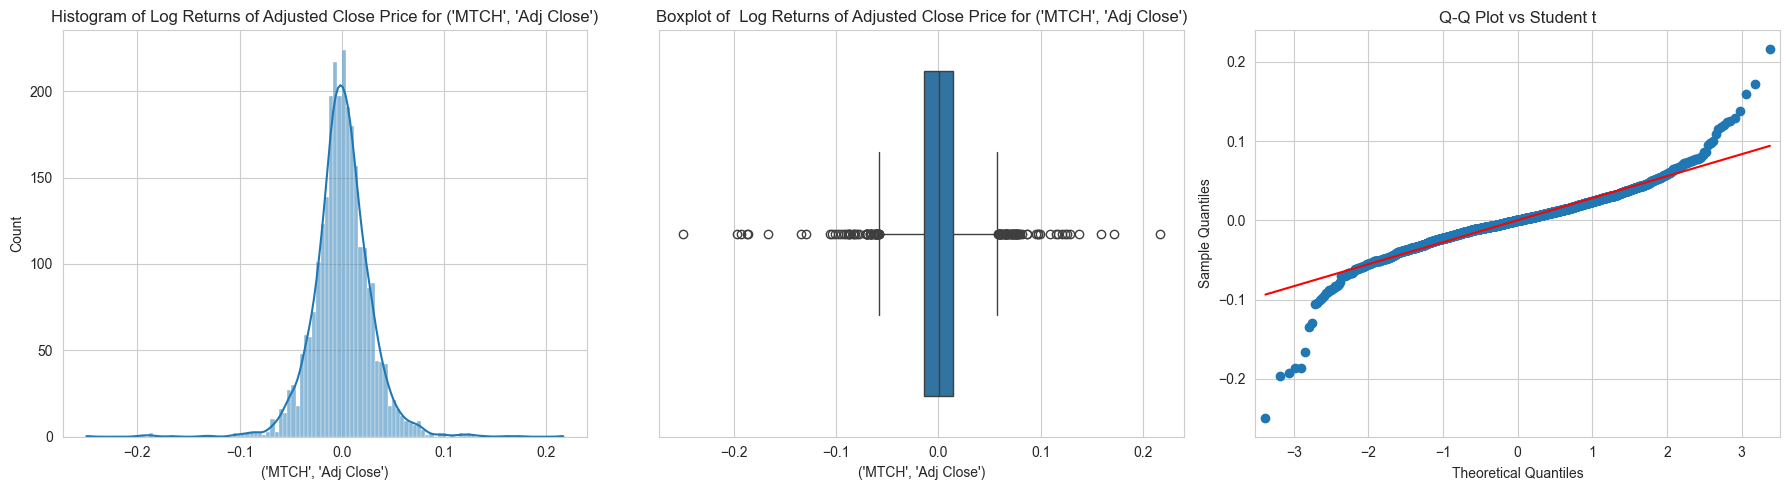

In [102]:
# Let's do our standard EDA on these columns. 

# First note - the initial distributions were tested and were quite non-normal, will do a long transformation adn try to fit t-distribution to each column
df = np.log(randomColumns).diff(1).dropna()
# Start with standard plots - histograms, boxplots and for each column. 

dist_name = "student t"

# Histogram 
for column in df.columns:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,5))

    column_to_plot = df[column]
    sns.histplot(column_to_plot, ax=ax[0], kde=True)
    ax[0].set_title(f"Histogram of Log Returns of Adjusted Close Price for {column_to_plot.name}")

    # Boxplot 
    sns.boxplot(column_to_plot, ax=ax[1], orient="h")
    ax[1].set_title(f"Boxplot of  Log Returns of Adjusted Close Price for {column_to_plot.name}")

    # QQ-Plot versus any distribution
    sm.qqplot(column_to_plot, ax=ax[2], dist = stats.norm, line="r")
    ax[2].set_title(f"Q-Q Plot vs {dist_name.capitalize()}")

    plt.tight_layout()
    plt.show()

Most of the distributions seem to be normal, lets move on to plotting some time series analyses.

## TSA Analysis Plots

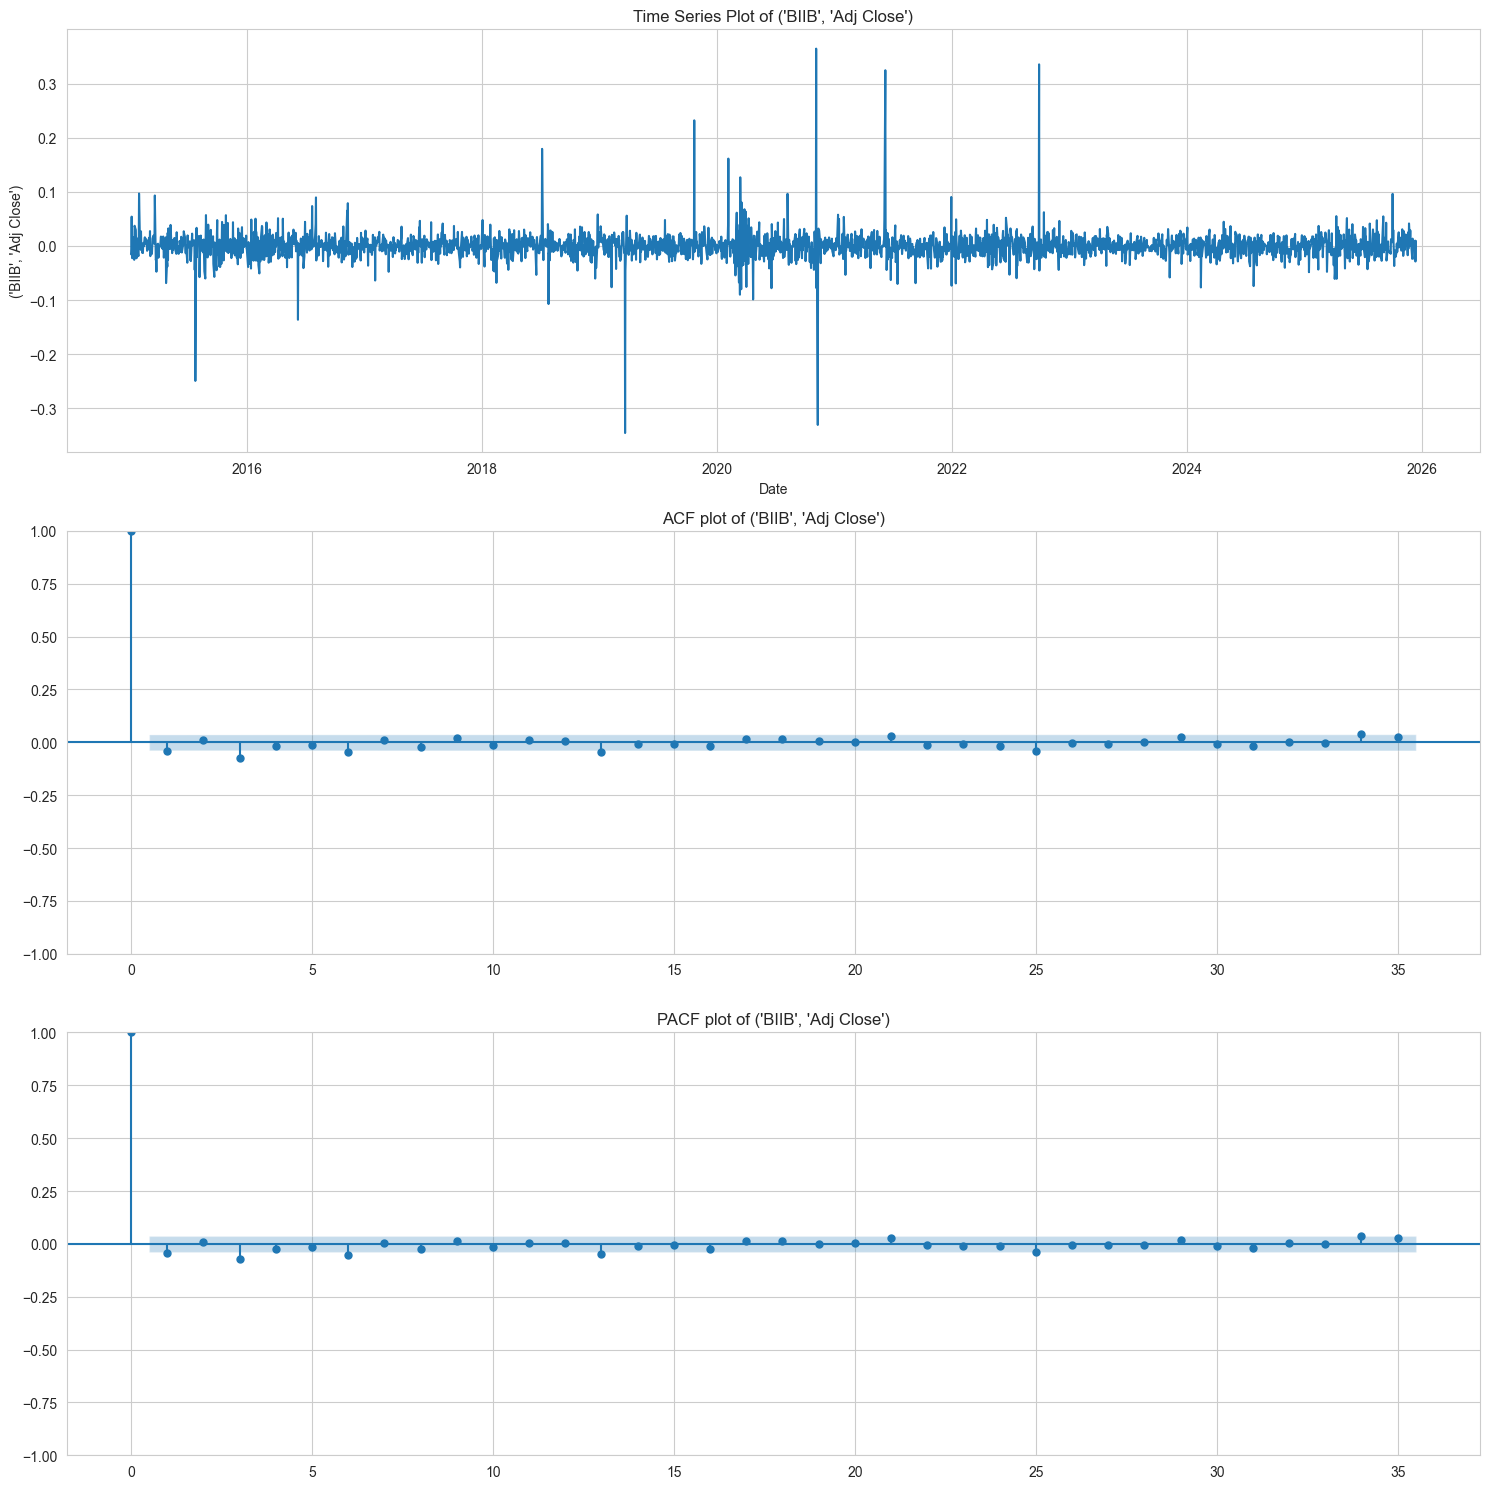

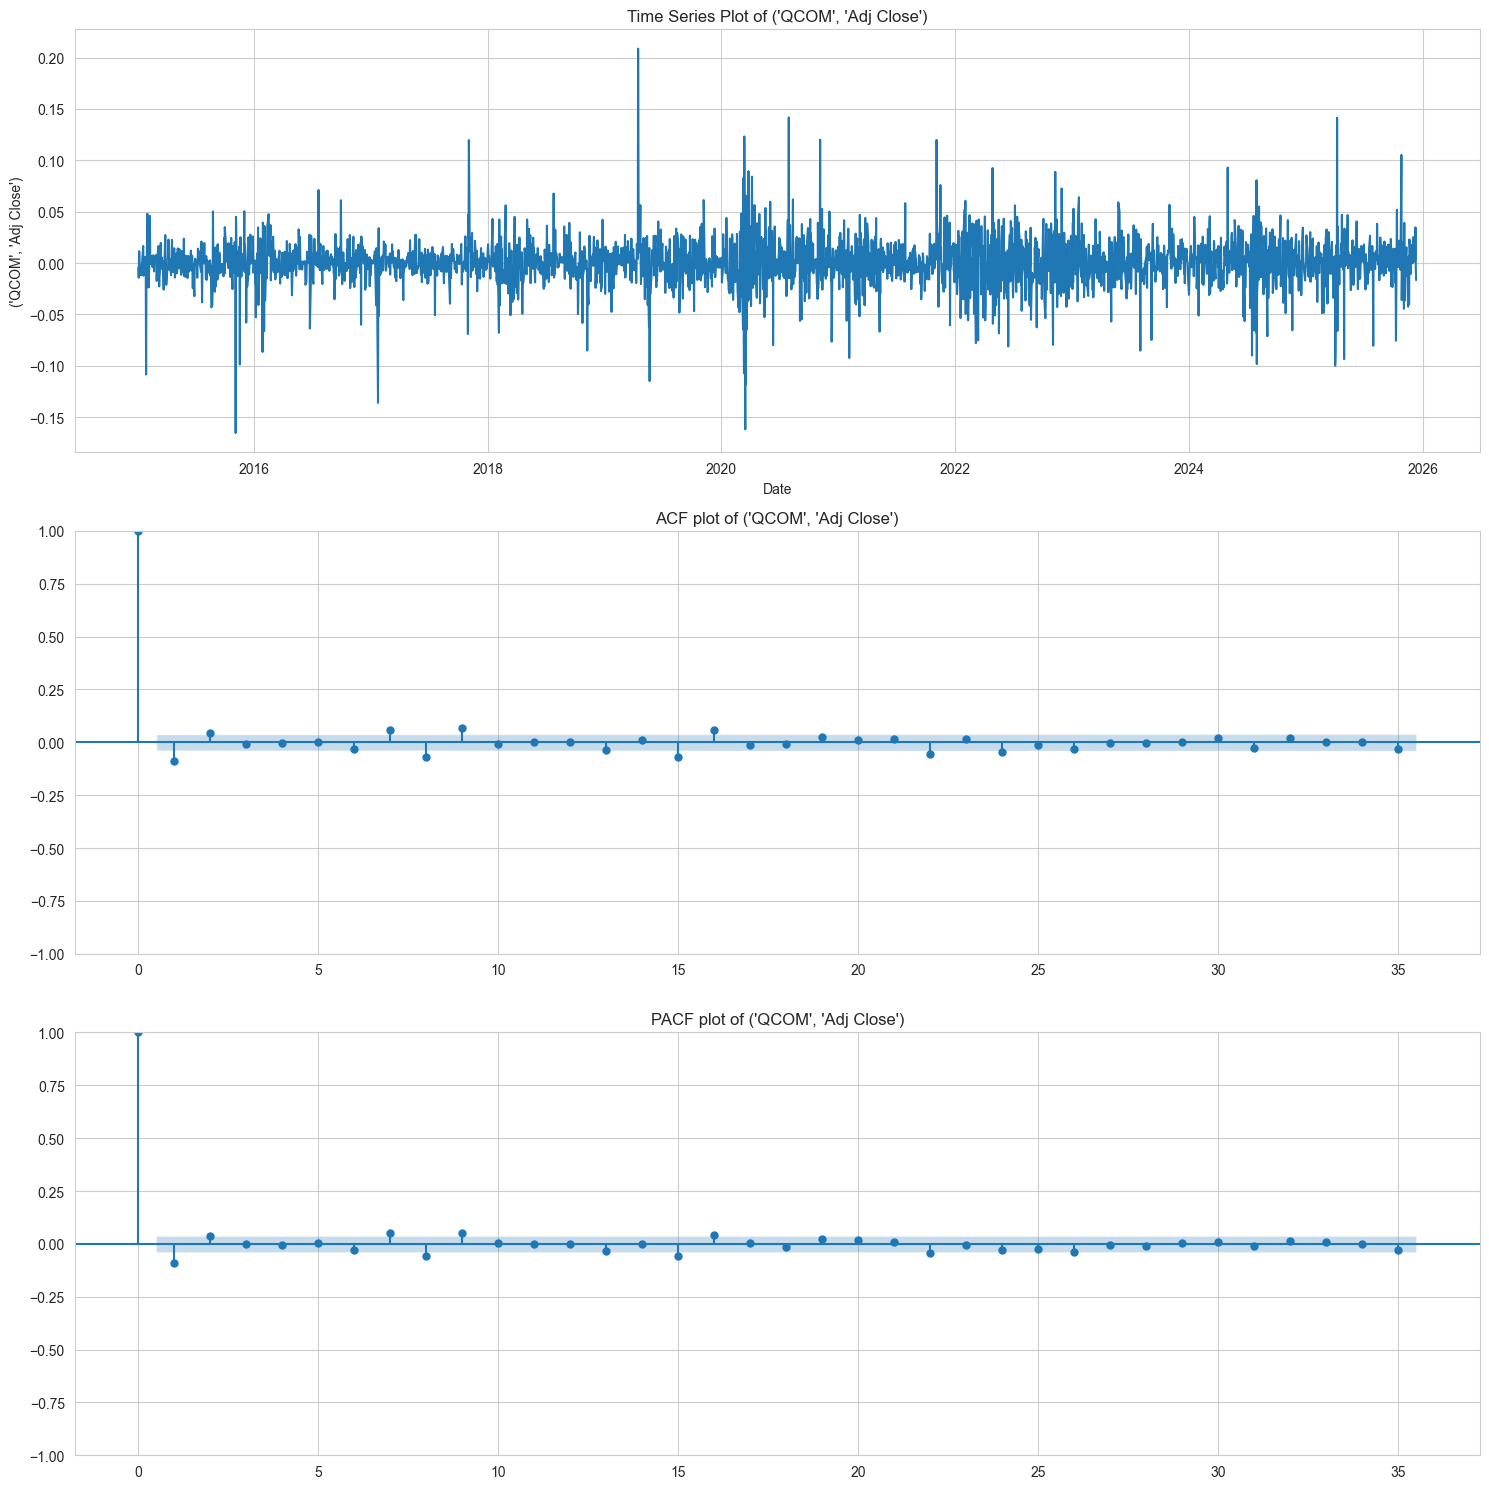

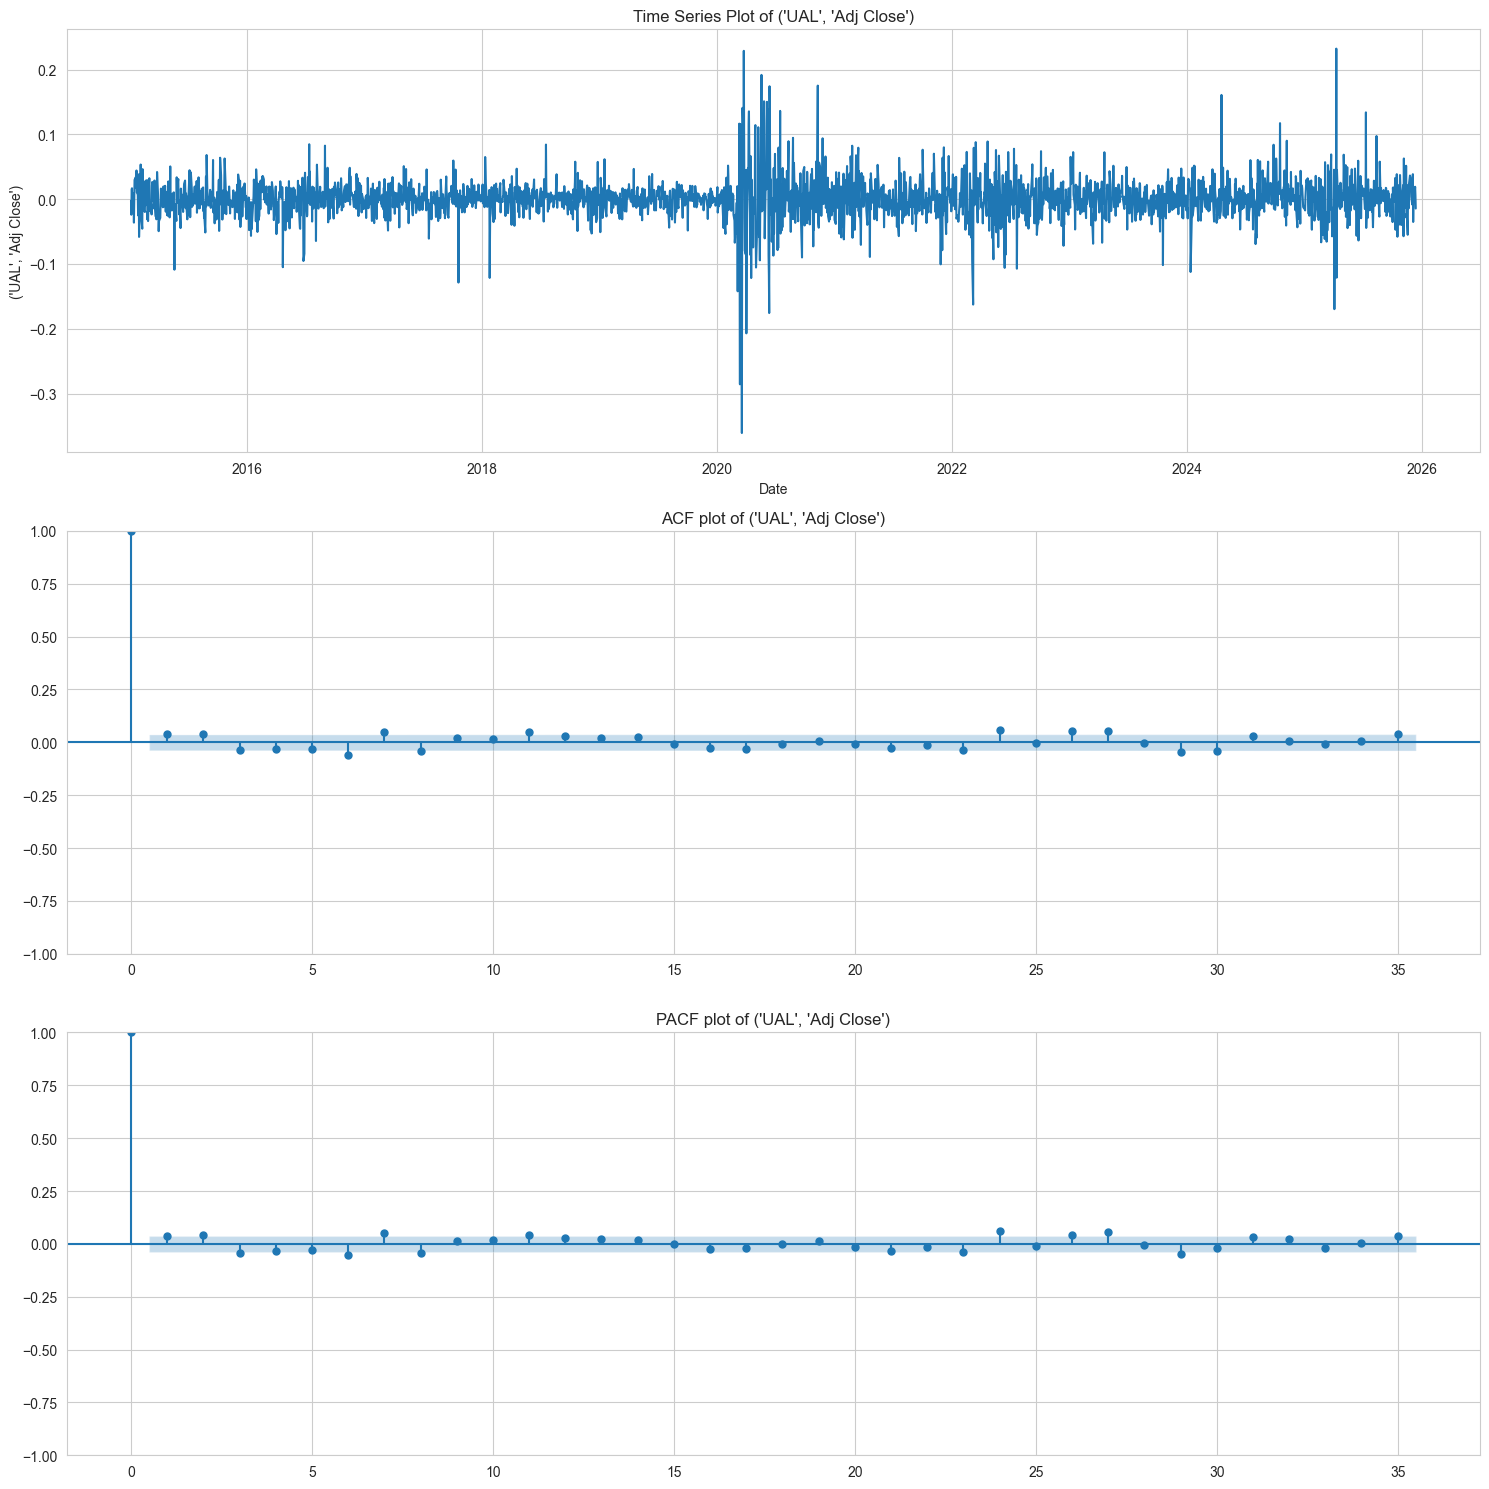

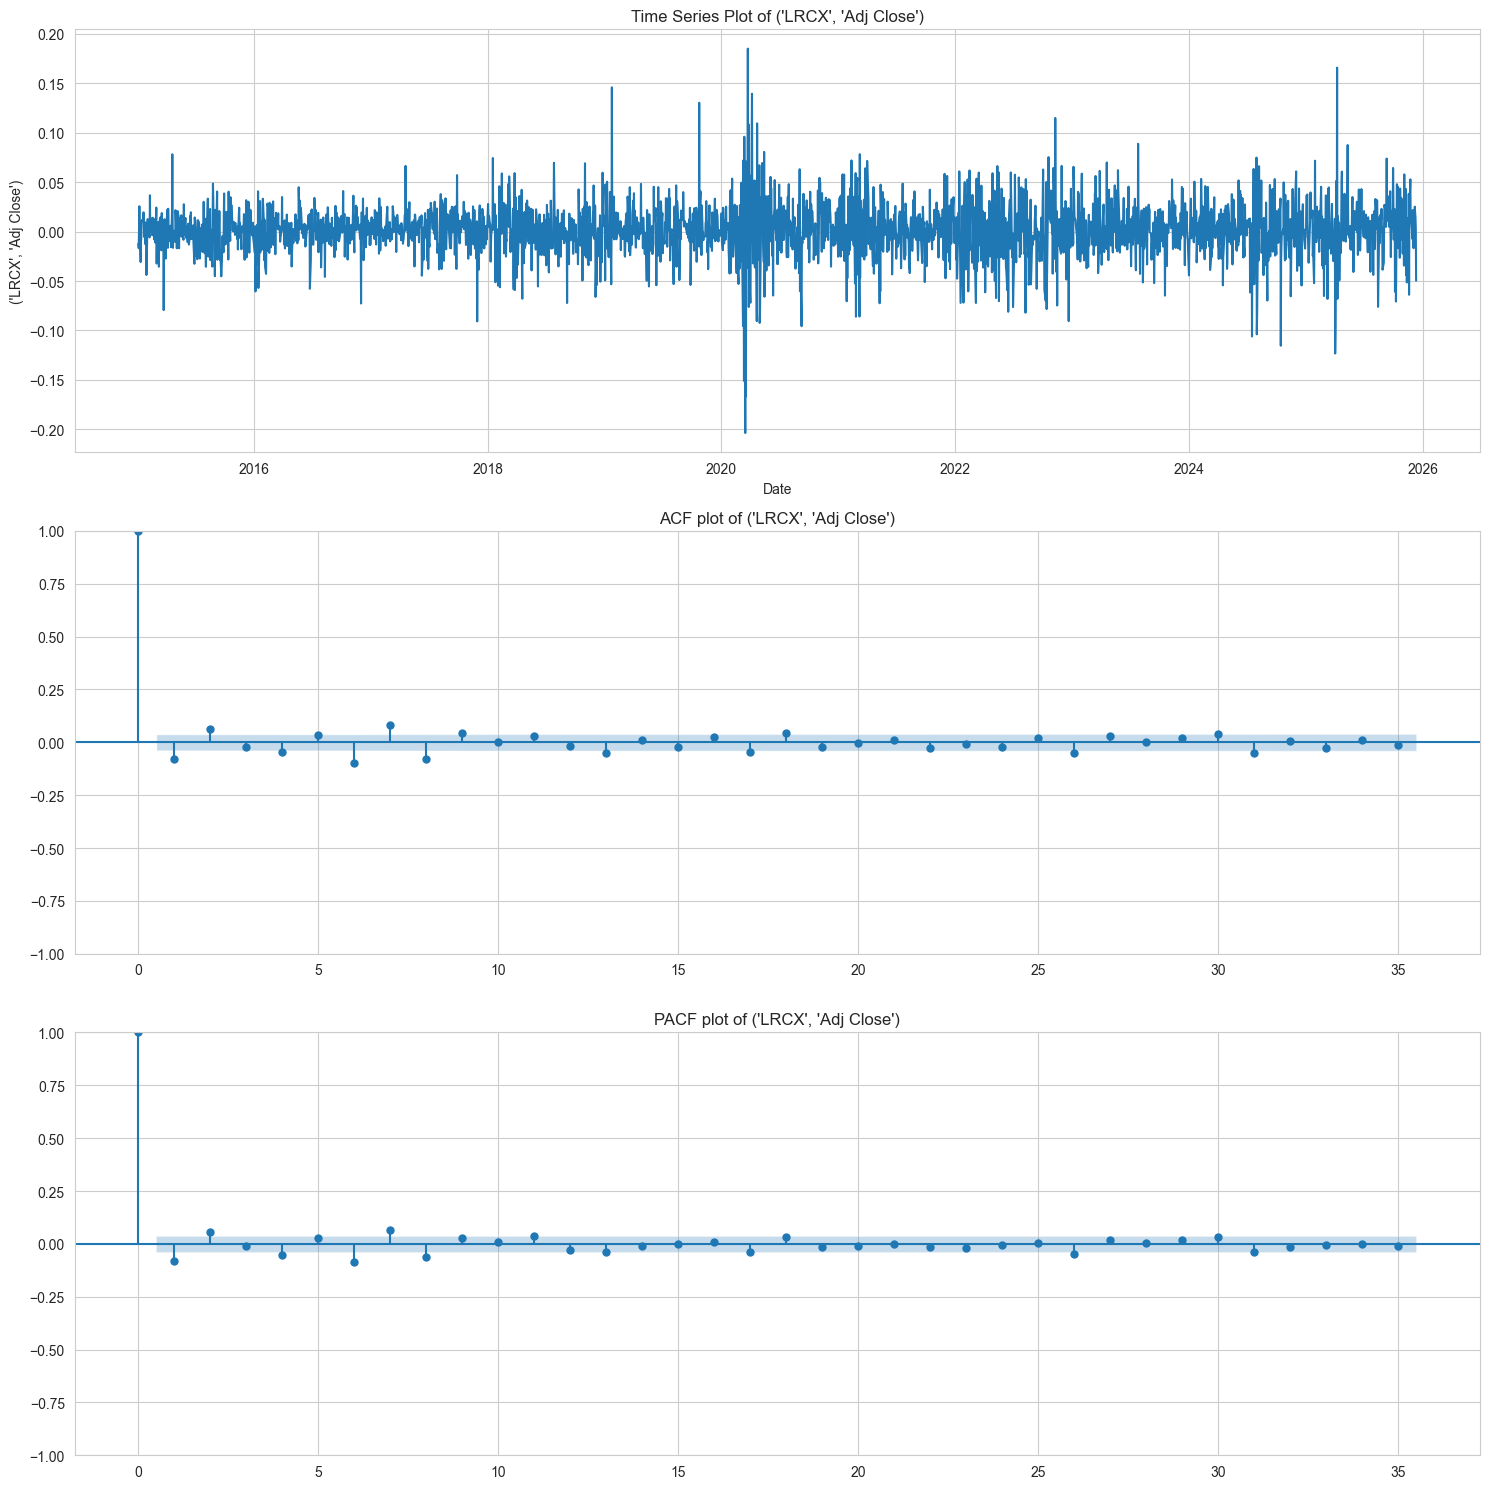

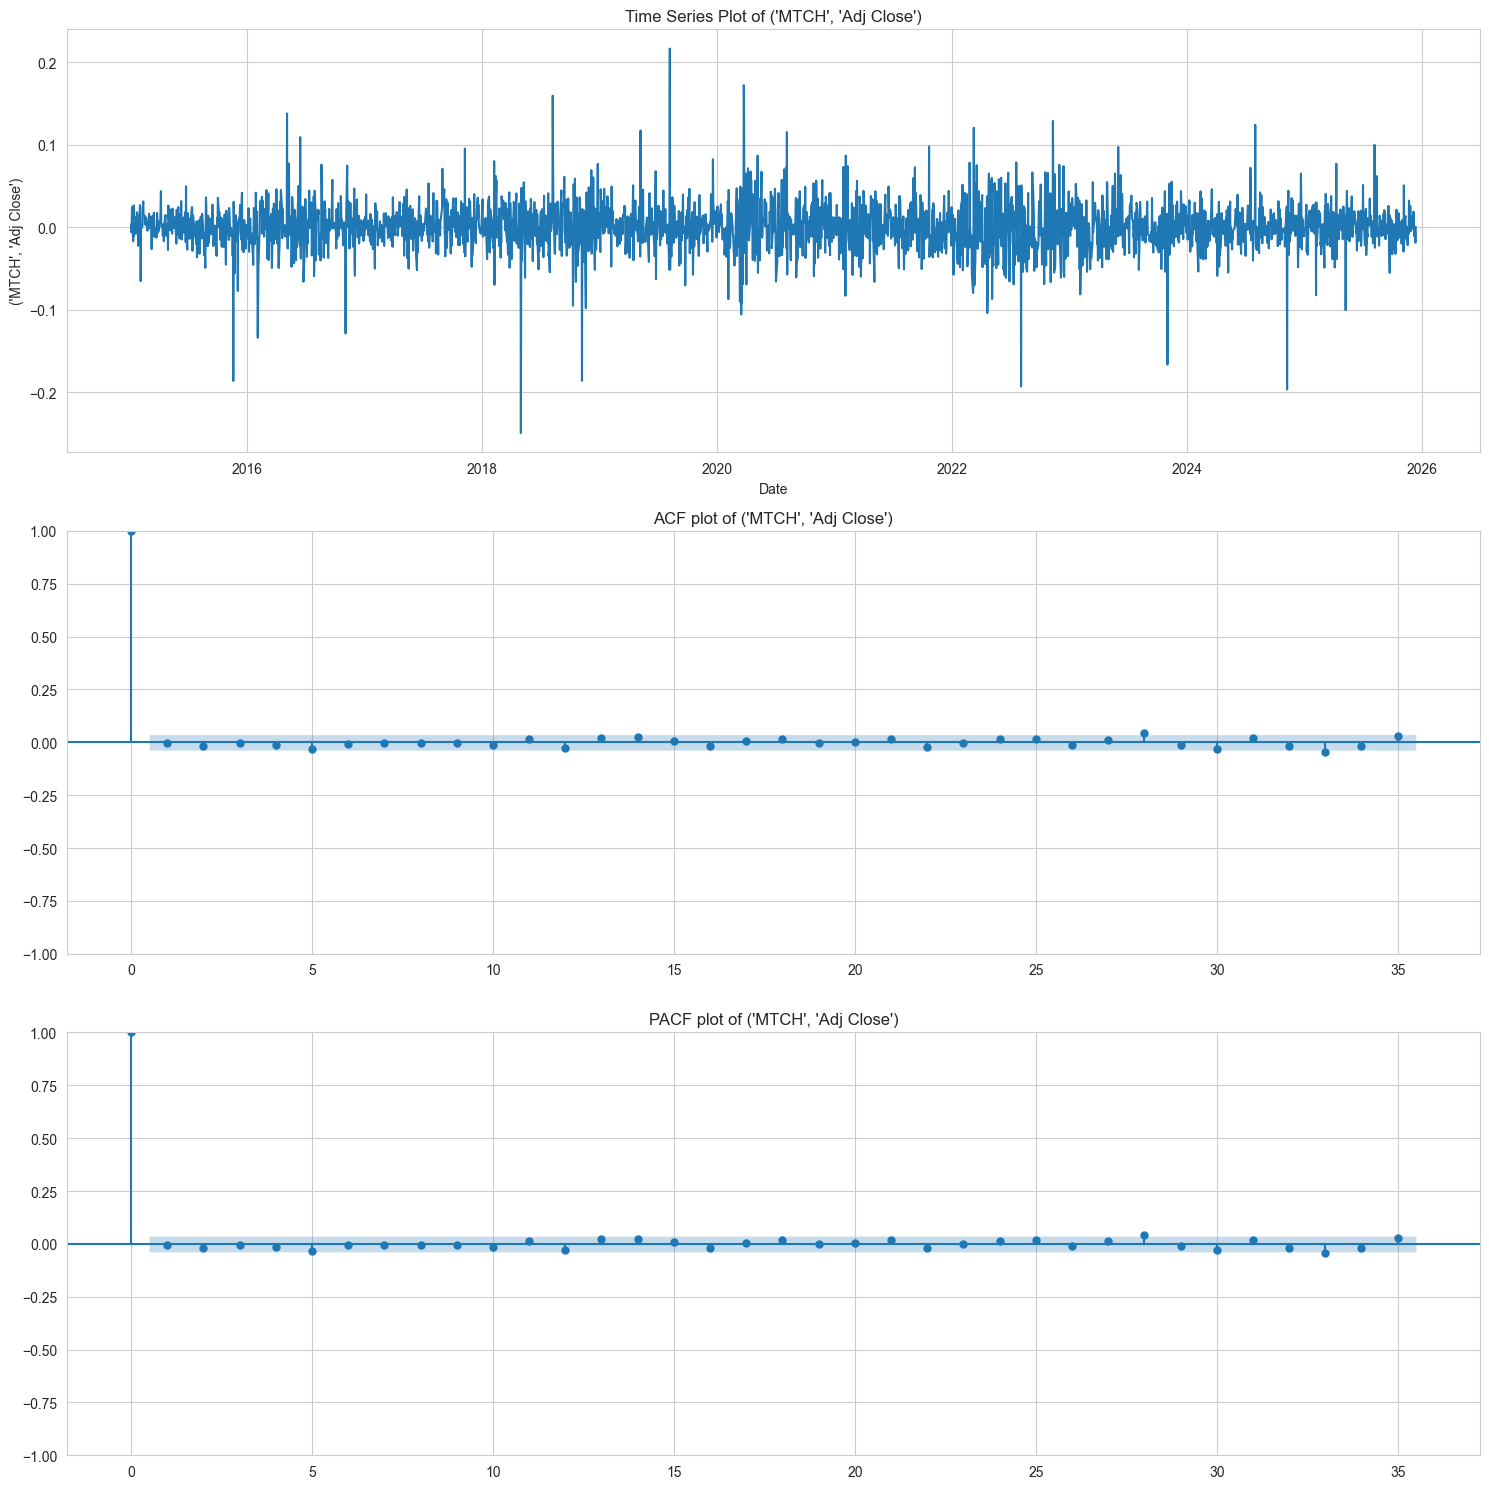

In [103]:

for column in df.columns:
    column_to_plot = df[column]
    fig, ax = plt.subplots(nrows= 3, ncols= 1, figsize=(15,15))

    # Basic time series plot 
    sns.lineplot(column_to_plot, ax=ax[0])
    ax[0].set_title(f"Time Series Plot of {column_to_plot.name}")

    plot_acf(column_to_plot, ax=ax[1])
    ax[1].set_title(f"ACF plot of {column_to_plot.name}")

    plot_pacf(column_to_plot, ax=ax[2])
    ax[2].set_title(f"PACF plot of {column_to_plot.name}")
    
    plt.tight_layout()
    plt.show()

## Correlation Heatmap Plot for each Ticker

It seems strange - there is no autocorrelation between the previous prices, perhaps time series modelling might not be the best idea. Moving on to plotting correlations:

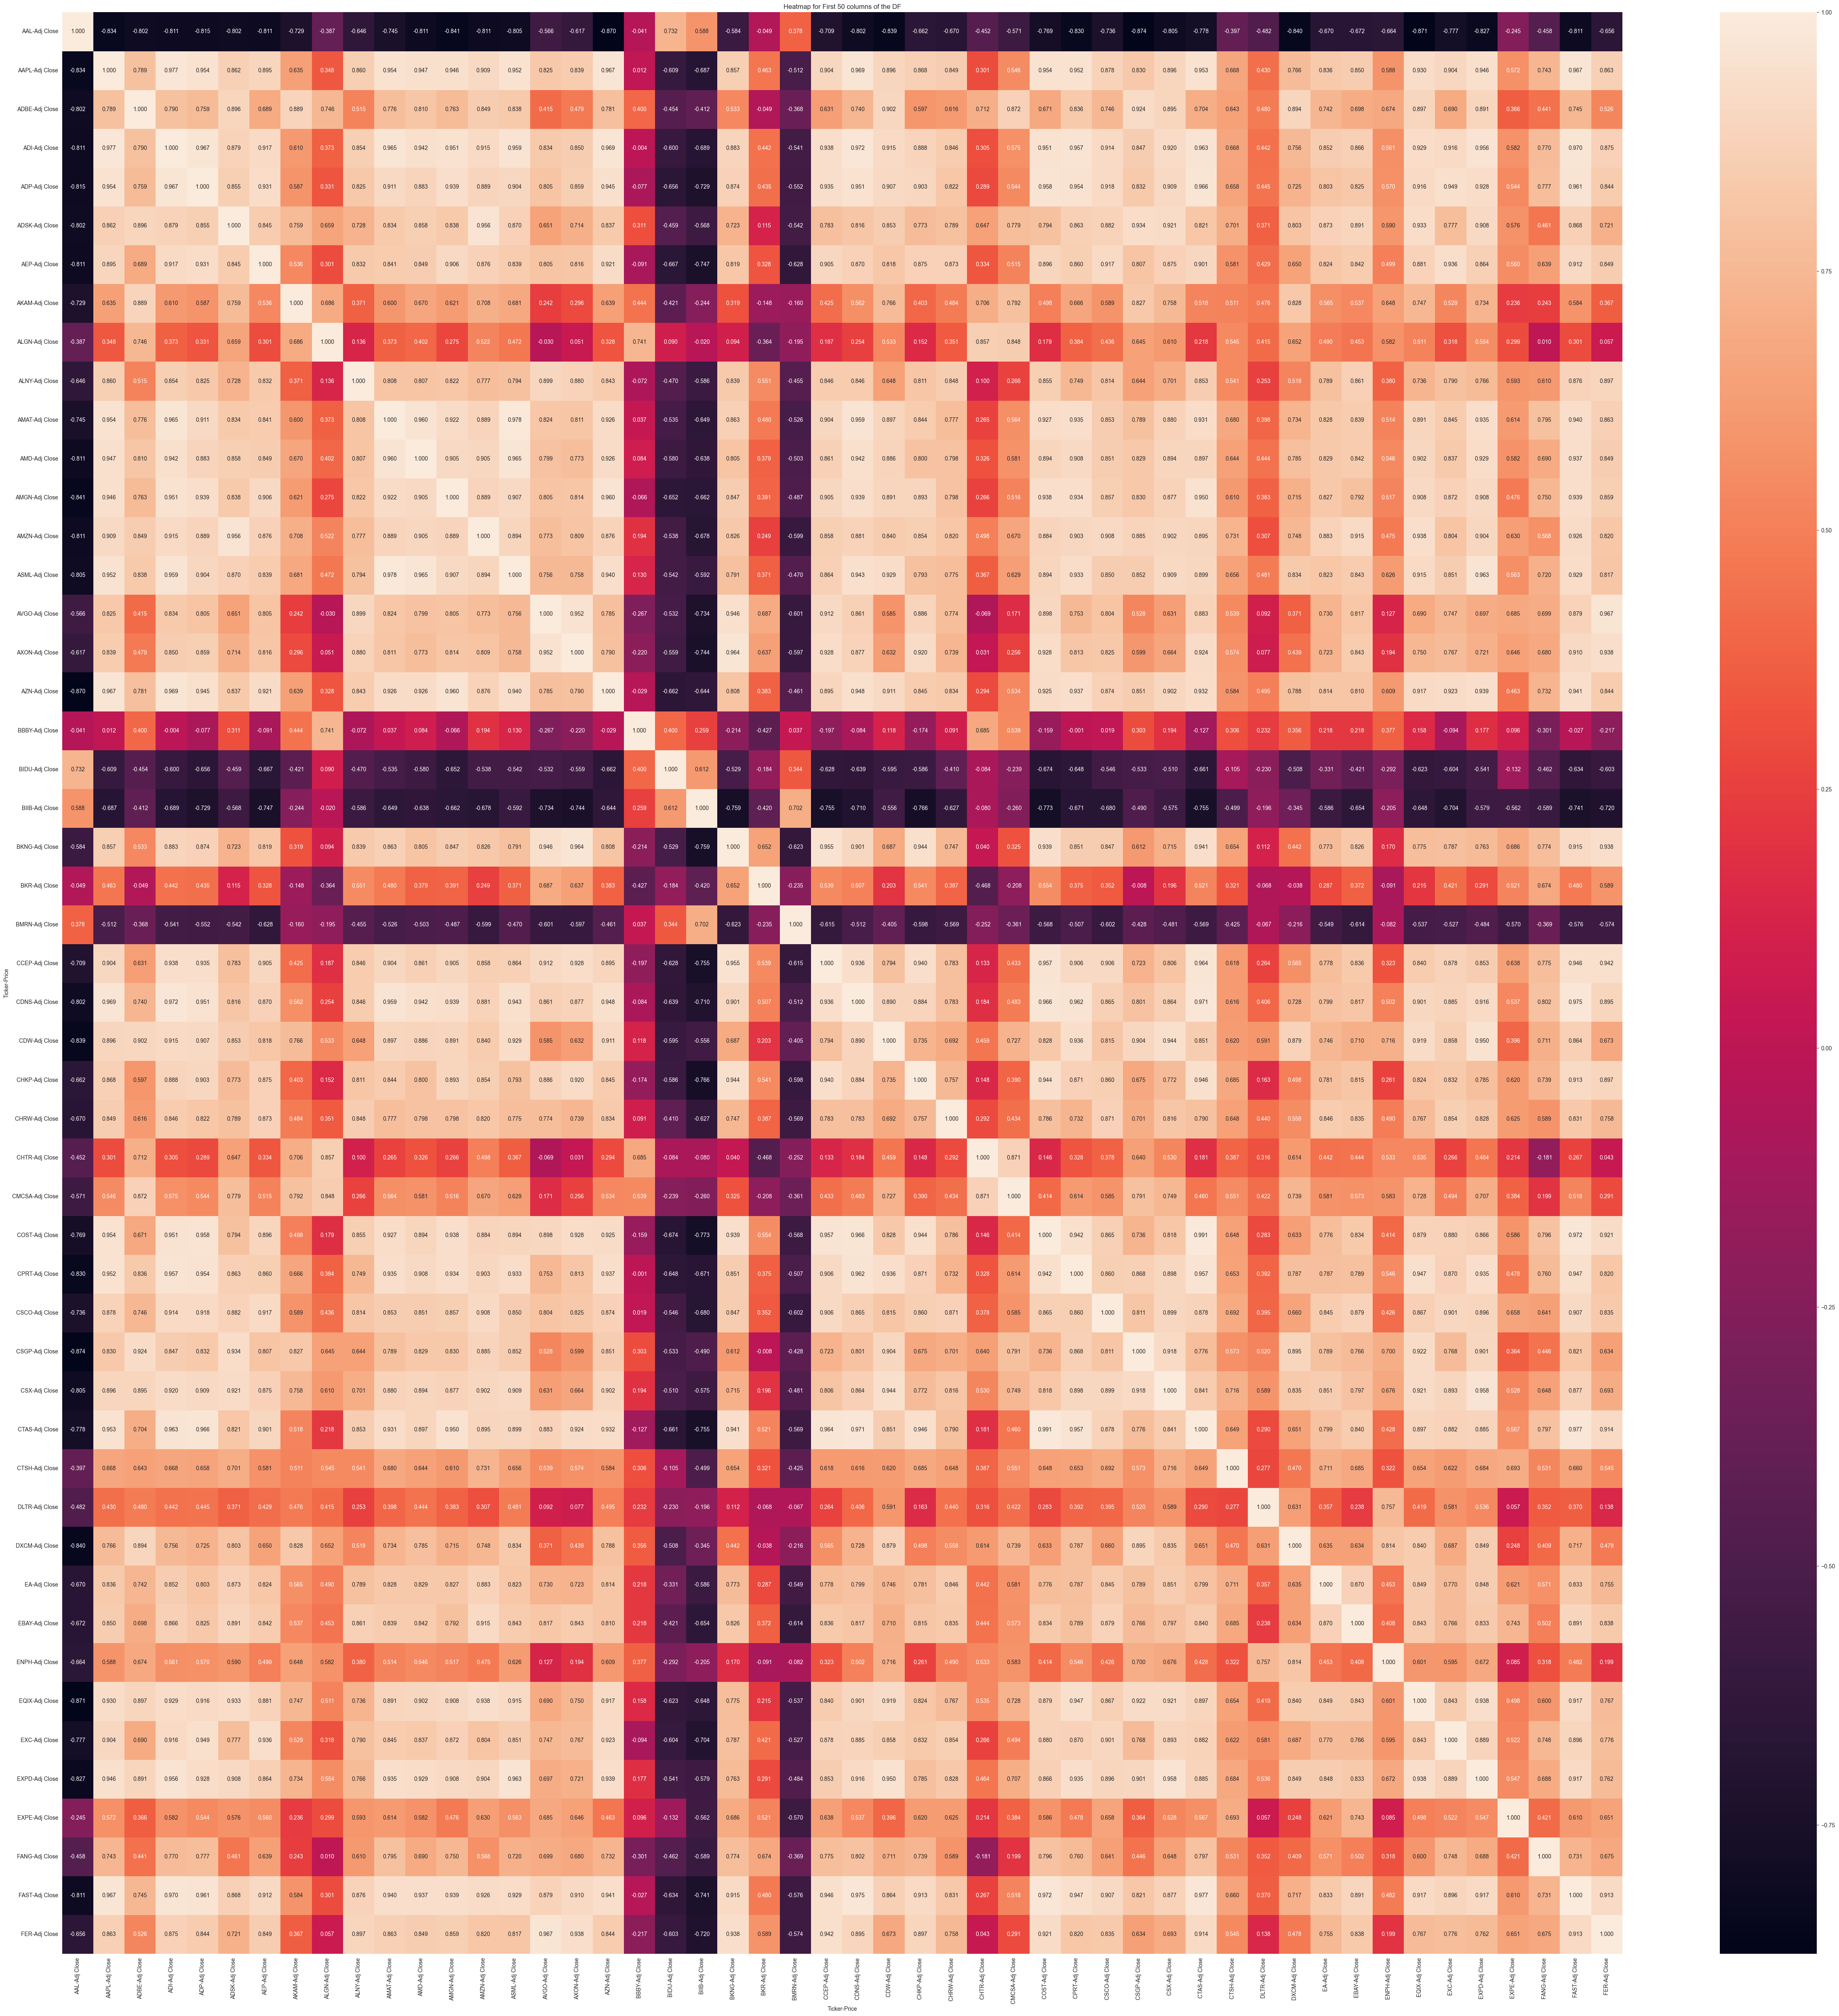

In [112]:
df = columnsToPlot.iloc[: , :50]
heatmap = df.corr()

fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(heatmap, annot=True, fmt=".3f", ax=ax)
plt.title("Heatmap for First 50 columns of the DF")
plt.tight_layout()
plt.savefig("Correlation HEatmap for First 50 columns of the DataFrame.pdf")
plt.show()


Conclusion - All tickers move very similarly together. There may be benefit in using other features to predict movement of current features, as well as applying PCA to reduce dimensionality.

# Definition of Alpha Universe:

For this section, we want to clearly define the stocks that we want to trade. The current candidates identified are

"AAPL", "GOOGL", "TSLA", "NVDA", "MSFT", "AMZN", "META", "AMD", "INTC", "CSCO"

In [ ]:
alpha = ["AAPL", "GOOGL", "TSLA", "NVDA", "MSFT", "AMZN", "META", "AMD", "INTC", "CSCO"]

Column AAPL is present in the DataFrame.
Column GOOGL is present in the DataFrame.
Column TSLA is present in the DataFrame.
Column NVDA is present in the DataFrame.
Column MSFT is present in the DataFrame.
Column AMZN is present in the DataFrame.
Column META is present in the DataFrame.
Column AMD is present in the DataFrame.
Column INTC is present in the DataFrame.
Column CSCO is present in the DataFrame.
